<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Depth_Anything_DA_C3VD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1twSOIn-ZceB3sK9l_9RUNXxDDVRqKh3g

Downloading...
From (original): https://drive.google.com/uc?id=1twSOIn-ZceB3sK9l_9RUNXxDDVRqKh3g
From (redirected): https://drive.google.com/uc?id=1twSOIn-ZceB3sK9l_9RUNXxDDVRqKh3g&confirm=t&uuid=fa4208d3-a2c9-4516-83b8-ee7e5d3e2d46
To: /content/C3VD.zip
100% 615M/615M [00:27<00:00, 22.6MB/s]


In [2]:
!unzip -q C3VD.zip

all ['/content/C3VD/trans_t1_a']
valid [0]
Prepared C3VD dataset with 59 sets of RGB, depth, normal and occlusion images.
test["color", 0, 0]: torch.Size([3, 256, 320]) tensor(0.) tensor(1.)
test["color_aug", 0, 0]: torch.Size([3, 256, 320]) tensor(0.) tensor(1.) torch.Size([1080, 1350])


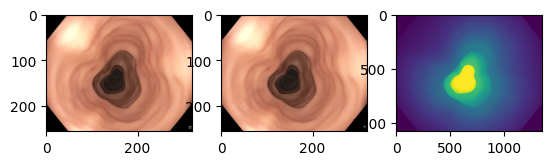

In [37]:
from __future__ import absolute_import, division, print_function

import glob
import os
import random
import numpy as np
from PIL import Image  # using pillow-simd for increased speed
from PIL import ImageFile
import cv2

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES=True

def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

class C3VDDataset(data.Dataset):
    """Superclass for monocular dataloaders

    Args:
        data_path
        filenames
        height
        width
        frame_idxs
        num_scales
        is_train
        img_ext
    """
    def __init__(self,
                 data_path,
                 height,
                 width,
                 frame_idxs,
                 num_scales,
                 model='train',
                 load_depth=False,
                 load_pose=False):
        super(C3VDDataset, self).__init__()

        self.data_path = data_path
        self.height = height
        self.width = width
        self.num_scales = num_scales
        self.interp = Image.LANCZOS

        self.frame_idxs = frame_idxs

        self.is_train = True if model == 'train' else False
        self.load_depth = load_depth
        self.load_pose = load_pose
        self.loader = pil_loader
        self.to_tensor = transforms.ToTensor()
        self.rescale_factor = 100 / 65535
        # We need to specify augmentations differently in newer versions of torchvision.
        # We first try the newer tuple version; if this fails we fall back to scalars

        self.K = np.array([[0.594, 0, 0.495, 0],
                           [0, 0.742, 0.506, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]], dtype=np.float32)
        if model == 'train':
            #self.valid_files = np.array([1, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 20, 22])
            self.valid_files = np.array([0])
        else:
            self.valid_files = np.array([0, 2, 5, 9, 12, 16, 19, 21])
        self.frame_idxs_max = np.max(np.abs(self.frame_idxs))

        try:
            self.brightness = (0.8, 1.2)
            self.contrast = (0.8, 1.2)
            self.saturation = (0.8, 1.2)
            self.hue = (-0.1, 0.1)
            transforms.transforms.ColorJitter(self.brightness,self.contrast,self.saturation,self.hue)
        except TypeError:
            self.brightness = 0.2
            self.contrast = 0.2
            self.saturation = 0.2
            self.hue = 0.1

        self.resize = {}
        for i in range(self.num_scales):
            s = 2 ** i
            self.resize[i] = transforms.Resize((self.height // s, self.width // s),
                                               interpolation=self.interp)
        self.scans = []
        self.video_files_all = [os.path.join(self.data_path, file) for file in os.listdir(self.data_path)]
        self.video_files_all.sort()
        print("all",self.video_files_all)
        print("valid",self.valid_files)

        self.video_files = [self.video_files_all[i] for i in self.valid_files]


        self.sequence_len = np.zeros([len(self.video_files)])
        for i, video_file in enumerate(self.video_files):
            image_paths = os.path.join(video_file, "*_color.png")
            video_base = os.path.basename(video_file)
            seq_image_paths = glob.glob(image_paths)
            seq_image_paths.sort()

            poses_path = os.path.join(video_file, "pose.txt")
            seq_poses = self.get_pose_video(poses_path)

            if self.frame_idxs_max > 0:
                seq_image_paths = seq_image_paths[self.frame_idxs_max:-self.frame_idxs_max]
                seq_poses = seq_poses[self.frame_idxs_max:-self.frame_idxs_max]
            if model == 'val':
                seq_image_paths = seq_image_paths[::80]
                seq_poses = seq_poses[::80]
            for j, seq_image_path in enumerate(seq_image_paths):
                filename = os.path.basename(seq_image_path)
                frame_index = int(filename[:4])
                seq_depth_path = os.path.join(self.data_path, video_base, "{:04d}_depth.tiff".format(frame_index))
                if os.path.exists(seq_image_path) and os.path.exists(seq_depth_path):
                    self.scans.append(
                        {
                            "seq_index": i,
                            "sequence": video_base,
                            "frame_index": frame_index,
                            "pose": seq_poses[j],
                            "length": len(seq_image_paths),
                        })
        print("Prepared C3VD dataset with %d sets of RGB, depth, normal and occlusion images." % (len(self.scans)))

    def __len__(self):
        return len(self.scans)

    def preprocess(self, inputs, color_aug):
        """Resize colour images to the required scales and augment if required

        We create the color_aug object in advance and apply the same augmentation to all
        images in this item. This ensures that all images input to the pose network receive the
        same augmentation.
        """
        for k in list(inputs):
            if "color" in k:
                n, im, i = k
                for i in range(self.num_scales):
                    inputs[(n, im, i)] = self.resize[i](inputs[(n, im, i - 1)])

        for k in list(inputs):
            f = inputs[k]
            if "color" in k:
                n, im, i = k
                inputs[(n, im, i)] = self.to_tensor(f)
                inputs[(n + "_aug", im, i)] = self.to_tensor(color_aug(f))

    def get_color(self, video_base, frame_index, do_flip):
        color_path = os.path.join(self.data_path, video_base, "{:04d}_color.png".format(frame_index))
        color = self.loader(color_path)

        if do_flip:
            color = color.transpose(Image.FLIP_LEFT_RIGHT)

        return color

    def get_depth(self, video_base, frame_index, do_flip):
        depth_path = os.path.join(self.data_path, video_base, "{:04d}_depth.tiff".format(frame_index))
        depth_gt = cv2.imread(depth_path, 3)
        depth_gt = np.array(depth_gt[:, :, 0])
        depth_gt = depth_gt.astype(np.float32, order='C') * self.rescale_factor
        if do_flip:
            depth_gt = np.fliplr(depth_gt)

        return depth_gt

    def get_pose(self, video_base, frame_index):
        file_path = os.path.join(self.data_path, video_base, "pose.txt")
        with open(file_path, 'r') as f:
            lines = f.read().splitlines()
        values = lines[frame_index].split(',')
        pose = np.array(values).astype(np.float32).reshape([4,4]).T

        return pose

    def get_pose_video(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.read().splitlines()
        poses = []
        for line in lines:
            values = line.split(',')
            if len(values) != 16:
                raise ValueError("Invalid camera pose format")
            pose = np.array(values).reshape([4,4]).T
            poses.append(pose)

        return np.array(poses)

    def __getitem__(self, index):
        """Returns a single training item from the dataset as a dictionary.

        Values correspond to torch tensors.
        Keys in the dictionary are either strings or tuples:

            ("color", <frame_id>, <scale>)          for raw colour images,
            ("color_aug", <frame_id>, <scale>)      for augmented colour images,
            ("K", scale) or ("inv_K", scale)        for camera intrinsics,
            "stereo_T"                              for camera extrinsics, and
            "depth_gt"                              for ground truth depth maps.

        <frame_id> is either:
            an integer (e.g. 0, -1, or 1) representing the temporal step relative to 'index',
        or
            "s" for the opposite image in the stereo pair.

        <scale> is an integer representing the scale of the image relative to the fullsize image:
            -1      images at native resolution as loaded from disk
            0       images resized to (self.width,      self.height     )
            1       images resized to (self.width // 2, self.height // 2)
            2       images resized to (self.width // 4, self.height // 4)
            3       images resized to (self.width // 8, self.height // 8)
        """
        scan = self.scans[index]
        video_base = scan["sequence"]
        frame_index = scan["frame_index"]

        inputs = {}

        do_color_aug = self.is_train and random.random() > 0.5
        do_flip = self.is_train and random.random() > 0.5

        inputs["frame_id"] = torch.from_numpy(np.array(frame_index))

        for idx, i in enumerate(self.frame_idxs):
            # print(frame_index + i, "color", i, -1)
            inputs[("color", i, -1)] = self.get_color(video_base, frame_index + i, do_flip)
            color_path = os.path.join(self.data_path, video_base, "{:04d}_color.png".format(frame_index + i))
            if idx == 0:
                inputs['path'] = color_path

        # adjusting intrinsics to match each scale in the pyramid
        for scale in range(self.num_scales):
            K = self.K.copy()
            K[0, :] *= self.width // (2 ** scale)
            K[1, :] *= self.height // (2 ** scale)


            inv_K = np.linalg.pinv(K)

            inputs[("K", scale)] = torch.from_numpy(K)
            inputs[("inv_K", scale)] = torch.from_numpy(inv_K)

        if do_color_aug:
            color_aug = transforms.ColorJitter(self.brightness,self.contrast,self.saturation,self.hue)
        else:
            color_aug = (lambda x: x)

        self.preprocess(inputs, color_aug)
        for i in self.frame_idxs:
            del inputs[("color", i, -1)]
            del inputs[("color_aug", i, -1)]

        if self.load_depth:
            # print('depth:',frame_index)
            depth_gt = self.get_depth(video_base, frame_index, do_flip)
            inputs["depth_gt"] = np.expand_dims(depth_gt, 0)
            inputs["depth_gt"] = torch.from_numpy(inputs["depth_gt"].astype(np.float32))
            # inputs["depth_gt"] = torch.from_numpy(depth_gt.astype(np.float32))
            # print('inputs["depth_gt"]:',inputs["depth_gt"].permute(1,2,0).shape)
            # inputs["depth_gt"] = self.resize[0](inputs["depth_gt"].permute(1,2,0))

        if self.load_pose:
            for i in self.frame_idxs:
                inputs[("pose", i)] = torch.from_numpy(self.get_pose(video_base, frame_index + i))
                inputs["sequence"] = video_base
                inputs["keyframe"] = "0"
        return inputs

dataset_c3vd = C3VDDataset(data_path='/content/C3VD', height=256, width=320, frame_idxs=[0, -1, 1], num_scales=4, load_depth=True)
dataloader = DataLoader(dataset_c3vd, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

test = dataset_c3vd[0]
plt.subplot(131); plt.imshow(test['color', 0, 0].permute(1,2,0))
plt.subplot(132); plt.imshow(test["color_aug", 0, 0].permute(1,2,0))
plt.subplot(133); plt.imshow(test['depth_gt'][0])

print('test["color", 0, 0]:', test["color", 0, 0].shape, test["color", 0, 0].min(), test["color", 0, 0].max())
print('test["color_aug", 0, 0]:', test["color_aug", 0, 0].shape, test["color_aug", 0, 0].min(), test["color_aug", 0, 0].max(), test['depth_gt'][0].shape)

all ['/content/C3VD/trans_t1_a']
valid [0]
Prepared C3VD dataset with 59 sets of RGB, depth, normal and occlusion images.
pred_disps: (59, 420, 518) gt_depths: (59, 1080, 1350)
 Scaling ratios | med: 177.473 | std: 0.062

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.616  &  10.261  &  20.908  &   0.704  &   0.260  &   0.459  &   0.628  \\
torch.Size([420, 518]) torch.Size([11, 1, 420, 518]) torch.Size([1080, 1350])


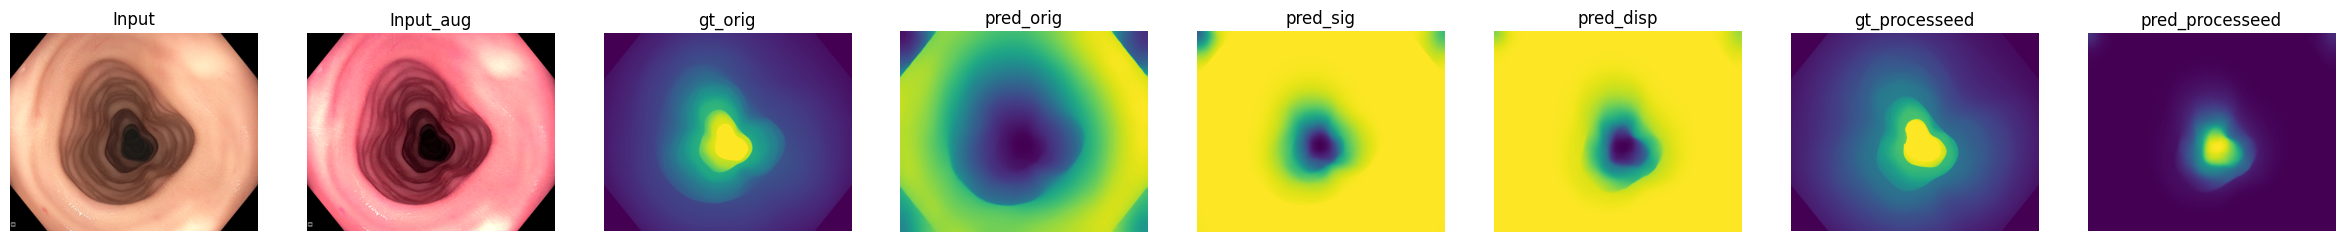

In [74]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from torch import nn

def disp_to_depth(disp, min_depth=0.1, max_depth=150):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_c3vd = C3VDDataset(data_path='/content/C3VD', height=256, width=320, frame_idxs=[0, -1, 1], num_scales=4, load_depth=True)
dataloader = DataLoader(dataset_c3vd, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model.to(device)
depth_model.eval()
# prepare image for the model
MIN_DEPTH = 1e-3
MAX_DEPTH = 150
pred_disps = []
gt_depths = []

with torch.no_grad():
    for sample_batch in dataloader:
        depth_gt =sample_batch['depth_gt'].to(device)
        inputs = image_processor(images=sample_batch['color', 0, 0], return_tensors="pt", do_rescale=False).to(device)
        outputs = depth_model(**inputs)
        predicted_depth = outputs.predicted_depth.unsqueeze(1)
        predicted_depth_sig = nn.Sigmoid()(predicted_depth)
        # print('predicted_depth', predicted_depth_sig.shape)
        pred_disp, _ = disp_to_depth(predicted_depth_sig)
        # print('pred_disp:', pred_disp.shape)
        pred_disp = pred_disp.cpu()[:, 0].numpy()
        pred_disps.append(pred_disp)
        gt_depths.append(sample_batch['depth_gt'])
        # prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),size=inputs['pixel_values'].shape[2:],mode="bicubic",align_corners=False)
        # break
    pred_disps = np.concatenate(pred_disps)
    gt_depths = np.concatenate(gt_depths).squeeze()

print('pred_disps:',pred_disps.shape, 'gt_depths:',gt_depths.shape)
errors = []
ratios = []

for i in range(pred_disps.shape[0]):
    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_disp = pred_disps[i]
    # print('pred_disp1:', pred_disp.shape)
    pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
    # print('pred_disp2:', pred_disp.shape)
    pred_depth = 1/pred_disp
    # print('pred_disp3:', pred_disp.shape)
    mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)
    # print('mask:', mask.shape, 'pred_depth:', pred_depth.shape)
    # print('pred_depth8:',pred_depth.shape, 'gt_depth8:',gt_depth.shape)
    if i == 0:
        vis_gt_depth = gt_depth
        vis_pred_depth = pred_depth
    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]
    # print('pred_depth9:',pred_depth.shape, 'gt_depth9:',gt_depth.shape)

    # pred_depth *= opt.pred_depth_scale_factor
    # if not opt.disable_median_scaling:
    ratio = np.median(gt_depth) / np.median(pred_depth)
    ratios.append(ratio)
    pred_depth *= ratio
    # print('pred_depth10:',pred_depth.shape, 'gt_depth10:',gt_depth.shape)
    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
    # print('pred_depth11:',pred_depth.shape, 'gt_depth11:',gt_depth.shape)

    errors.append(compute_errors(gt_depth, pred_depth))


ratios = np.array(ratios)
med = np.median(ratios)
print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))

mean_errors = np.array(errors).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
plt.rcParams['figure.figsize'] = [30, 8]
plt.subplot(181); plt.axis('OFF'); plt.title('Input'); plt.imshow(sample_batch['color', 0, 0][0].permute(1,2,0))
plt.subplot(182); plt.axis('OFF'); plt.title('Input_aug'); plt.imshow(sample_batch["color_aug", 0, 0][0].permute(1,2,0))
plt.subplot(183); plt.axis('OFF'); plt.title('gt_orig'); plt.imshow(sample_batch['depth_gt'][0][0].cpu())
plt.subplot(184); plt.axis('OFF'); plt.title('pred_orig'); plt.imshow(predicted_depth[0][0].cpu())
plt.subplot(185); plt.axis('OFF'); plt.title('pred_sig'); plt.imshow(predicted_depth_sig[0][0].cpu())
plt.subplot(186); plt.axis('OFF'); plt.title('pred_disp'); plt.imshow(pred_disps[0])
plt.subplot(187); plt.axis('OFF'); plt.title('gt_processeed'); plt.imshow(vis_gt_depth)
plt.subplot(188); plt.axis('OFF'); plt.title('pred_processeed'); plt.imshow(vis_pred_depth)
print(inputs['pixel_values'].shape[2:], predicted_depth.shape, sample_batch['depth_gt'][0][0].shape)

LiheYoung/depth-anything-small-hf

all ['/content/C3VD/trans_t1_a']
valid [0]
Prepared C3VD dataset with 59 sets of RGB, depth, normal and occlusion images.
pred_disps: (59, 252, 308) gt_depths: (59, 1080, 1350)
 Scaling ratios | med: 177.067 | std: 0.062

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.618  &  10.589  &  21.559  &   0.726  &   0.261  &   0.459  &   0.626  \\
torch.Size([420, 518]) torch.Size([11, 1, 252, 308]) torch.Size([1080, 1350])


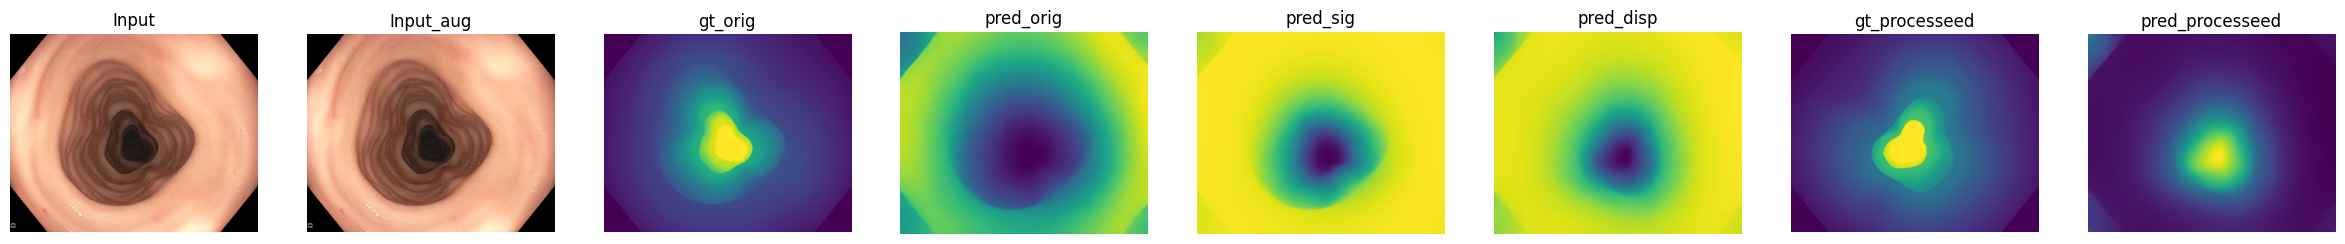

In [76]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from torch import nn

def disp_to_depth(disp, min_depth=0.1, max_depth=150):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_c3vd = C3VDDataset(data_path='/content/C3VD', height=256, width=320, frame_idxs=[0, -1, 1], num_scales=4, load_depth=True)
dataloader = DataLoader(dataset_c3vd, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

pretrained_weights = "LiheYoung/depth-anything-small-hf"
image_processor = AutoImageProcessor.from_pretrained(pretrained_weights)
depth_model = DepthAnythingForDepthEstimation.from_pretrained(pretrained_weights)
depth_model.to(device)
depth_model.eval()
# prepare image for the model
MIN_DEPTH = 1e-3
MAX_DEPTH = 150
pred_disps = []
gt_depths = []

with torch.no_grad():
    for sample_batch in dataloader:
        depth_gt =sample_batch['depth_gt'].to(device)
        inputs = image_processor(images=sample_batch['color', 0, 0], return_tensors="pt", do_rescale=False).to(device)
        outputs = depth_model(**inputs)
        # outputs = depth_model(sample_batch['color', 0, 0].to(device))
        predicted_depth = outputs.predicted_depth.unsqueeze(1)
        predicted_depth_sig = nn.Sigmoid()(predicted_depth)
        # print('predicted_depth', predicted_depth_sig.shape)
        pred_disp, _ = disp_to_depth(predicted_depth_sig)
        # print('pred_disp:', pred_disp.shape)
        pred_disp = pred_disp.cpu()[:, 0].numpy()
        pred_disps.append(pred_disp)
        gt_depths.append(sample_batch['depth_gt'])
        # prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),size=inputs['pixel_values'].shape[2:],mode="bicubic",align_corners=False)
        # break
    pred_disps = np.concatenate(pred_disps)
    gt_depths = np.concatenate(gt_depths).squeeze()

print('pred_disps:',pred_disps.shape, 'gt_depths:',gt_depths.shape)
errors = []
ratios = []

for i in range(pred_disps.shape[0]):
    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_disp = pred_disps[i]
    # print('pred_disp1:', pred_disp.shape)
    pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
    # print('pred_disp2:', pred_disp.shape)
    pred_depth = 1/pred_disp
    # print('pred_disp3:', pred_disp.shape)
    mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)
    # print('mask:', mask.shape, 'pred_depth:', pred_depth.shape)
    # print('pred_depth8:',pred_depth.shape, 'gt_depth8:',gt_depth.shape)
    if i == 0:
        vis_gt_depth = gt_depth
        vis_pred_depth = pred_depth
    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]
    # print('pred_depth9:',pred_depth.shape, 'gt_depth9:',gt_depth.shape)

    # pred_depth *= opt.pred_depth_scale_factor
    # if not opt.disable_median_scaling:
    ratio = np.median(gt_depth) / np.median(pred_depth)
    ratios.append(ratio)
    pred_depth *= ratio
    # print('pred_depth10:',pred_depth.shape, 'gt_depth10:',gt_depth.shape)
    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
    # print('pred_depth11:',pred_depth.shape, 'gt_depth11:',gt_depth.shape)

    errors.append(compute_errors(gt_depth, pred_depth))


ratios = np.array(ratios)
med = np.median(ratios)
print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))

mean_errors = np.array(errors).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
plt.rcParams['figure.figsize'] = [30, 8]
plt.subplot(181); plt.axis('OFF'); plt.title('Input'); plt.imshow(sample_batch['color', 0, 0][0].permute(1,2,0))
plt.subplot(182); plt.axis('OFF'); plt.title('Input_aug'); plt.imshow(sample_batch["color_aug", 0, 0][0].permute(1,2,0))
plt.subplot(183); plt.axis('OFF'); plt.title('gt_orig'); plt.imshow(sample_batch['depth_gt'][0][0].cpu())
plt.subplot(184); plt.axis('OFF'); plt.title('pred_orig'); plt.imshow(predicted_depth[0][0].cpu())
plt.subplot(185); plt.axis('OFF'); plt.title('pred_sig'); plt.imshow(predicted_depth_sig[0][0].cpu())
plt.subplot(186); plt.axis('OFF'); plt.title('pred_disp'); plt.imshow(pred_disps[0])
plt.subplot(187); plt.axis('OFF'); plt.title('gt_processeed'); plt.imshow(vis_gt_depth)
plt.subplot(188); plt.axis('OFF'); plt.title('pred_processeed'); plt.imshow(vis_pred_depth)
print(inputs['pixel_values'].shape[2:], predicted_depth.shape, sample_batch['depth_gt'][0][0].shape)

depth-anything/Depth-Anything-V2-Small-hf

all ['/content/C3VD/trans_t1_a']
valid [0]
Prepared C3VD dataset with 59 sets of RGB, depth, normal and occlusion images.
sample size: 59
pred_disps: (59, 420, 518) gt_depths: (59, 1080, 1350)
 Scaling ratios | med: 172.200 | std: 0.058

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.577  &   8.500  &  18.328  &   0.615  &   0.277  &   0.489  &   0.685  \\
torch.Size([420, 518]) torch.Size([11, 1, 420, 518]) torch.Size([1080, 1350])


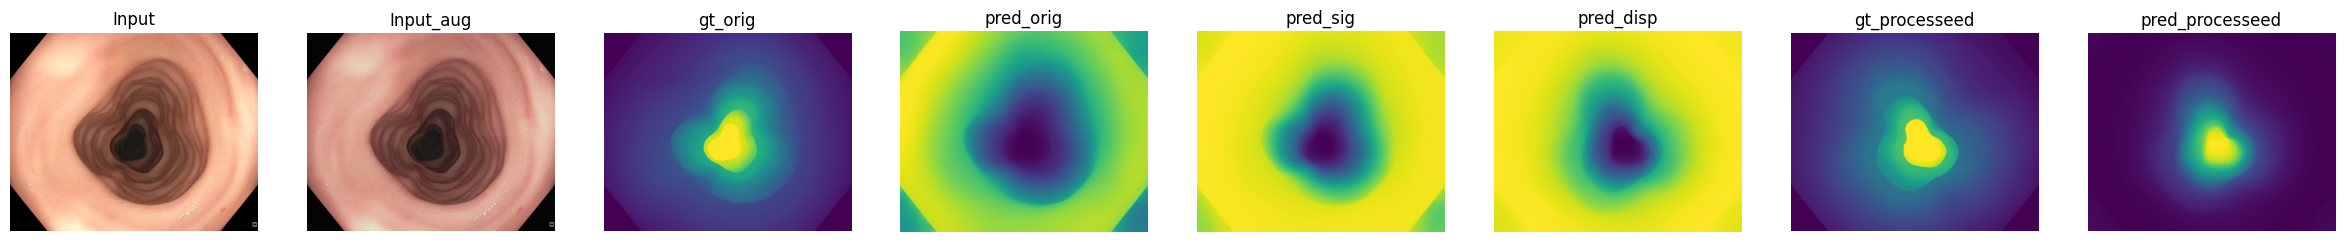

In [78]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from torch import nn

def disp_to_depth(disp, min_depth=0.1, max_depth=150):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_c3vd = C3VDDataset(data_path='/content/C3VD', height=256, width=320, frame_idxs=[0, -1, 1], num_scales=4, load_depth=True)
dataloader = DataLoader(dataset_c3vd, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)
print('sample size:', len(dataset_c3vd))
pretrained_weights = "depth-anything/Depth-Anything-V2-Small-hf"
image_processor = AutoImageProcessor.from_pretrained(pretrained_weights)
depth_model = DepthAnythingForDepthEstimation.from_pretrained(pretrained_weights)
depth_model.to(device)
depth_model.eval()
# prepare image for the model
MIN_DEPTH = 1e-3
MAX_DEPTH = 150
pred_disps = []
gt_depths = []

with torch.no_grad():
    for sample_batch in dataloader:
        depth_gt =sample_batch['depth_gt'].to(device)
        inputs = image_processor(images=sample_batch['color', 0, 0], return_tensors="pt", do_rescale=False).to(device)
        outputs = depth_model(**inputs)
        # outputs = depth_model(sample_batch['color', 0, 0].to(device))
        predicted_depth = outputs.predicted_depth.unsqueeze(1)
        predicted_depth_sig = nn.Sigmoid()(predicted_depth)
        # print('predicted_depth', predicted_depth_sig.shape)
        pred_disp, _ = disp_to_depth(predicted_depth_sig)
        # print('pred_disp:', pred_disp.shape)
        pred_disp = pred_disp.cpu()[:, 0].numpy()
        pred_disps.append(pred_disp)
        gt_depths.append(sample_batch['depth_gt'])
        # prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),size=inputs['pixel_values'].shape[2:],mode="bicubic",align_corners=False)
        # break
    pred_disps = np.concatenate(pred_disps)
    gt_depths = np.concatenate(gt_depths).squeeze()

print('pred_disps:',pred_disps.shape, 'gt_depths:',gt_depths.shape)
errors = []
ratios = []

for i in range(pred_disps.shape[0]):
    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_disp = pred_disps[i]
    # print('pred_disp1:', pred_disp.shape)
    pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
    # print('pred_disp2:', pred_disp.shape)
    pred_depth = 1/pred_disp
    # print('pred_disp3:', pred_disp.shape)
    mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)
    # print('mask:', mask.shape, 'pred_depth:', pred_depth.shape)
    # print('pred_depth8:',pred_depth.shape, 'gt_depth8:',gt_depth.shape)
    if i == 0:
        vis_gt_depth = gt_depth
        vis_pred_depth = pred_depth
    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]
    # print('pred_depth9:',pred_depth.shape, 'gt_depth9:',gt_depth.shape)

    # pred_depth *= opt.pred_depth_scale_factor
    # if not opt.disable_median_scaling:
    ratio = np.median(gt_depth) / np.median(pred_depth)
    ratios.append(ratio)
    pred_depth *= ratio
    # print('pred_depth10:',pred_depth.shape, 'gt_depth10:',gt_depth.shape)
    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
    # print('pred_depth11:',pred_depth.shape, 'gt_depth11:',gt_depth.shape)

    errors.append(compute_errors(gt_depth, pred_depth))


ratios = np.array(ratios)
med = np.median(ratios)
print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))

mean_errors = np.array(errors).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
plt.rcParams['figure.figsize'] = [30, 8]
plt.subplot(181); plt.axis('OFF'); plt.title('Input'); plt.imshow(sample_batch['color', 0, 0][0].permute(1,2,0))
plt.subplot(182); plt.axis('OFF'); plt.title('Input_aug'); plt.imshow(sample_batch["color_aug", 0, 0][0].permute(1,2,0))
plt.subplot(183); plt.axis('OFF'); plt.title('gt_orig'); plt.imshow(sample_batch['depth_gt'][0][0].cpu())
plt.subplot(184); plt.axis('OFF'); plt.title('pred_orig'); plt.imshow(predicted_depth[0][0].cpu())
plt.subplot(185); plt.axis('OFF'); plt.title('pred_sig'); plt.imshow(predicted_depth_sig[0][0].cpu())
plt.subplot(186); plt.axis('OFF'); plt.title('pred_disp'); plt.imshow(pred_disps[0])
plt.subplot(187); plt.axis('OFF'); plt.title('gt_processeed'); plt.imshow(vis_gt_depth)
plt.subplot(188); plt.axis('OFF'); plt.title('pred_processeed'); plt.imshow(vis_pred_depth)
print(inputs['pixel_values'].shape[2:], predicted_depth.shape, sample_batch['depth_gt'][0][0].shape)

depth-anything/Depth-Anything-V2-Base-hf

all ['/content/C3VD/trans_t1_a']
valid [0]
Prepared C3VD dataset with 59 sets of RGB, depth, normal and occlusion images.
sample size: 59


preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/390M [00:00<?, ?B/s]

pred_disps: (59, 252, 308) gt_depths: (59, 1080, 1350)
 Scaling ratios | med: 177.142 | std: 0.061

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.614  &  10.223  &  20.927  &   0.703  &   0.261  &   0.461  &   0.631  \\
torch.Size([420, 518]) torch.Size([11, 1, 252, 308]) torch.Size([1080, 1350])


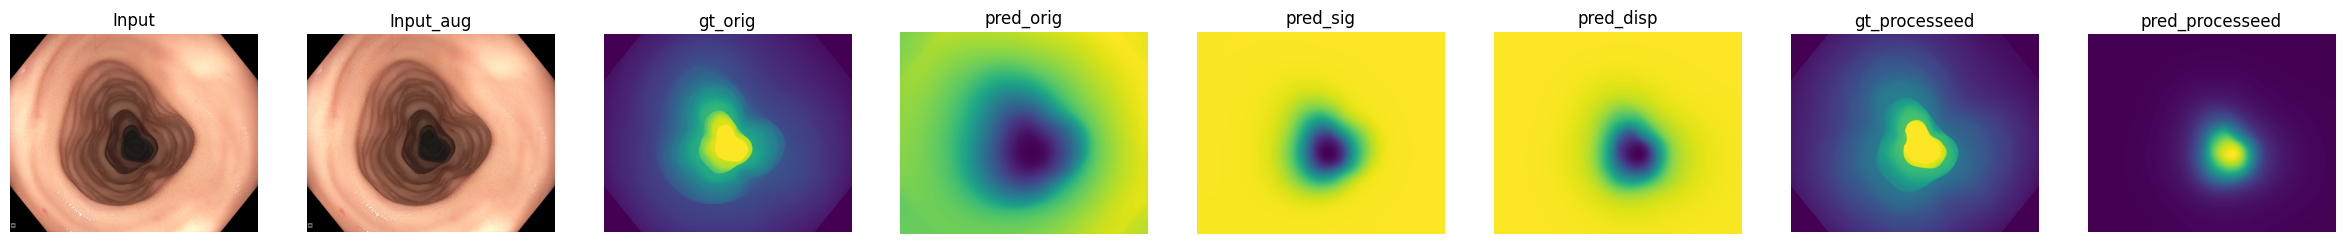

In [79]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from torch import nn

def disp_to_depth(disp, min_depth=0.1, max_depth=150):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_c3vd = C3VDDataset(data_path='/content/C3VD', height=256, width=320, frame_idxs=[0, -1, 1], num_scales=4, load_depth=True)
dataloader = DataLoader(dataset_c3vd, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)
print('sample size:', len(dataset_c3vd))
pretrained_weights = "depth-anything/Depth-Anything-V2-Base-hf"
image_processor = AutoImageProcessor.from_pretrained(pretrained_weights)
depth_model = DepthAnythingForDepthEstimation.from_pretrained(pretrained_weights)
depth_model.to(device)
depth_model.eval()
# prepare image for the model
MIN_DEPTH = 1e-3
MAX_DEPTH = 150
pred_disps = []
gt_depths = []

with torch.no_grad():
    for sample_batch in dataloader:
        depth_gt =sample_batch['depth_gt'].to(device)
        # inputs = image_processor(images=sample_batch['color', 0, 0], return_tensors="pt", do_rescale=False).to(device)
        # outputs = depth_model(**inputs)
        outputs = depth_model(sample_batch['color', 0, 0].to(device))
        predicted_depth = outputs.predicted_depth.unsqueeze(1)
        predicted_depth_sig = nn.Sigmoid()(predicted_depth)
        # print('predicted_depth', predicted_depth_sig.shape)
        pred_disp, _ = disp_to_depth(predicted_depth_sig)
        # print('pred_disp:', pred_disp.shape)
        pred_disp = pred_disp.cpu()[:, 0].numpy()
        pred_disps.append(pred_disp)
        gt_depths.append(sample_batch['depth_gt'])
        # prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),size=inputs['pixel_values'].shape[2:],mode="bicubic",align_corners=False)
        # break
    pred_disps = np.concatenate(pred_disps)
    gt_depths = np.concatenate(gt_depths).squeeze()

print('pred_disps:',pred_disps.shape, 'gt_depths:',gt_depths.shape)
errors = []
ratios = []

for i in range(pred_disps.shape[0]):
    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_disp = pred_disps[i]
    # print('pred_disp1:', pred_disp.shape)
    pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
    # print('pred_disp2:', pred_disp.shape)
    pred_depth = 1/pred_disp
    # print('pred_disp3:', pred_disp.shape)
    mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)
    # print('mask:', mask.shape, 'pred_depth:', pred_depth.shape)
    # print('pred_depth8:',pred_depth.shape, 'gt_depth8:',gt_depth.shape)
    if i == 0:
        vis_gt_depth = gt_depth
        vis_pred_depth = pred_depth
    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]
    # print('pred_depth9:',pred_depth.shape, 'gt_depth9:',gt_depth.shape)

    # pred_depth *= opt.pred_depth_scale_factor
    # if not opt.disable_median_scaling:
    ratio = np.median(gt_depth) / np.median(pred_depth)
    ratios.append(ratio)
    pred_depth *= ratio
    # print('pred_depth10:',pred_depth.shape, 'gt_depth10:',gt_depth.shape)
    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
    # print('pred_depth11:',pred_depth.shape, 'gt_depth11:',gt_depth.shape)

    errors.append(compute_errors(gt_depth, pred_depth))


ratios = np.array(ratios)
med = np.median(ratios)
print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))

mean_errors = np.array(errors).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
plt.rcParams['figure.figsize'] = [30, 8]
plt.subplot(181); plt.axis('OFF'); plt.title('Input'); plt.imshow(sample_batch['color', 0, 0][0].permute(1,2,0))
plt.subplot(182); plt.axis('OFF'); plt.title('Input_aug'); plt.imshow(sample_batch["color_aug", 0, 0][0].permute(1,2,0))
plt.subplot(183); plt.axis('OFF'); plt.title('gt_orig'); plt.imshow(sample_batch['depth_gt'][0][0].cpu())
plt.subplot(184); plt.axis('OFF'); plt.title('pred_orig'); plt.imshow(predicted_depth[0][0].cpu())
plt.subplot(185); plt.axis('OFF'); plt.title('pred_sig'); plt.imshow(predicted_depth_sig[0][0].cpu())
plt.subplot(186); plt.axis('OFF'); plt.title('pred_disp'); plt.imshow(pred_disps[0])
plt.subplot(187); plt.axis('OFF'); plt.title('gt_processeed'); plt.imshow(vis_gt_depth)
plt.subplot(188); plt.axis('OFF'); plt.title('pred_processeed'); plt.imshow(vis_pred_depth)
print(inputs['pixel_values'].shape[2:], predicted_depth.shape, sample_batch['depth_gt'][0][0].shape)

depth-anything/Depth-Anything-V2-Large-hf

all ['/content/C3VD/trans_t1_a']
valid [0]
Prepared C3VD dataset with 59 sets of RGB, depth, normal and occlusion images.
sample size: 59


preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

pred_disps: (59, 252, 308) gt_depths: (59, 1080, 1350)
 Scaling ratios | med: 177.523 | std: 0.062

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.620  &  10.680  &  21.675  &   0.732  &   0.259  &   0.457  &   0.624  \\
torch.Size([420, 518]) torch.Size([11, 1, 252, 308]) torch.Size([1080, 1350])


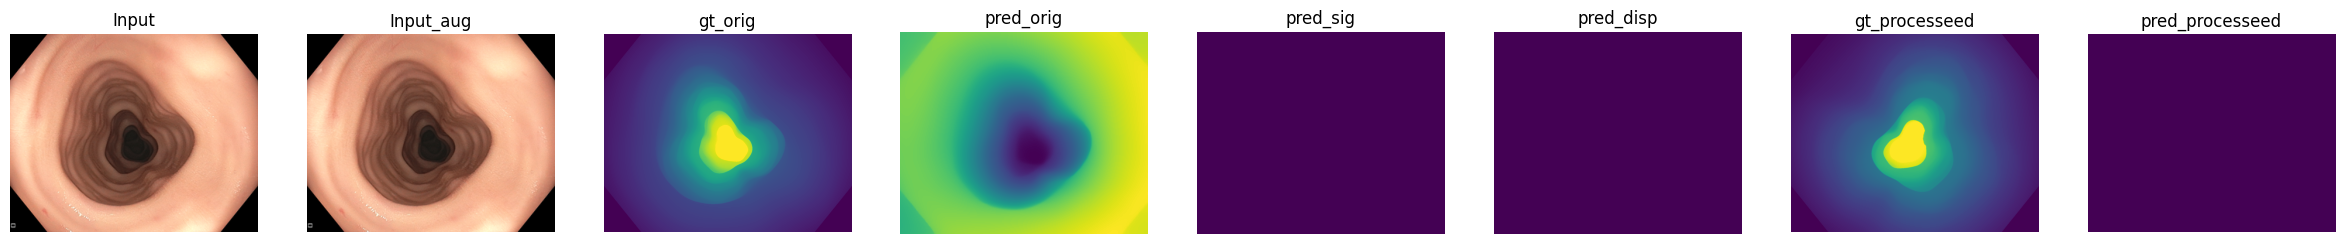

In [80]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from torch import nn

def disp_to_depth(disp, min_depth=0.1, max_depth=150):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_c3vd = C3VDDataset(data_path='/content/C3VD', height=256, width=320, frame_idxs=[0, -1, 1], num_scales=4, load_depth=True)
dataloader = DataLoader(dataset_c3vd, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)
print('sample size:', len(dataset_c3vd))
pretrained_weights = "depth-anything/Depth-Anything-V2-Large-hf"
image_processor = AutoImageProcessor.from_pretrained(pretrained_weights)
depth_model = DepthAnythingForDepthEstimation.from_pretrained(pretrained_weights)
depth_model.to(device)
depth_model.eval()
# prepare image for the model
MIN_DEPTH = 1e-3
MAX_DEPTH = 150
pred_disps = []
gt_depths = []

with torch.no_grad():
    for sample_batch in dataloader:
        depth_gt =sample_batch['depth_gt'].to(device)
        # inputs = image_processor(images=sample_batch['color', 0, 0], return_tensors="pt", do_rescale=False).to(device)
        # outputs = depth_model(**inputs)
        outputs = depth_model(sample_batch['color', 0, 0].to(device))
        predicted_depth = outputs.predicted_depth.unsqueeze(1)
        predicted_depth_sig = nn.Sigmoid()(predicted_depth)
        # print('predicted_depth', predicted_depth_sig.shape)
        pred_disp, _ = disp_to_depth(predicted_depth_sig)
        # print('pred_disp:', pred_disp.shape)
        pred_disp = pred_disp.cpu()[:, 0].numpy()
        pred_disps.append(pred_disp)
        gt_depths.append(sample_batch['depth_gt'])
        # prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),size=inputs['pixel_values'].shape[2:],mode="bicubic",align_corners=False)
        # break
    pred_disps = np.concatenate(pred_disps)
    gt_depths = np.concatenate(gt_depths).squeeze()

print('pred_disps:',pred_disps.shape, 'gt_depths:',gt_depths.shape)
errors = []
ratios = []

for i in range(pred_disps.shape[0]):
    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_disp = pred_disps[i]
    # print('pred_disp1:', pred_disp.shape)
    pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
    # print('pred_disp2:', pred_disp.shape)
    pred_depth = 1/pred_disp
    # print('pred_disp3:', pred_disp.shape)
    mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)
    # print('mask:', mask.shape, 'pred_depth:', pred_depth.shape)
    # print('pred_depth8:',pred_depth.shape, 'gt_depth8:',gt_depth.shape)
    if i == 0:
        vis_gt_depth = gt_depth
        vis_pred_depth = pred_depth
    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]
    # print('pred_depth9:',pred_depth.shape, 'gt_depth9:',gt_depth.shape)

    # pred_depth *= opt.pred_depth_scale_factor
    # if not opt.disable_median_scaling:
    ratio = np.median(gt_depth) / np.median(pred_depth)
    ratios.append(ratio)
    pred_depth *= ratio
    # print('pred_depth10:',pred_depth.shape, 'gt_depth10:',gt_depth.shape)
    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
    # print('pred_depth11:',pred_depth.shape, 'gt_depth11:',gt_depth.shape)

    errors.append(compute_errors(gt_depth, pred_depth))


ratios = np.array(ratios)
med = np.median(ratios)
print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))

mean_errors = np.array(errors).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
plt.rcParams['figure.figsize'] = [30, 8]
plt.subplot(181); plt.axis('OFF'); plt.title('Input'); plt.imshow(sample_batch['color', 0, 0][0].permute(1,2,0))
plt.subplot(182); plt.axis('OFF'); plt.title('Input_aug'); plt.imshow(sample_batch["color_aug", 0, 0][0].permute(1,2,0))
plt.subplot(183); plt.axis('OFF'); plt.title('gt_orig'); plt.imshow(sample_batch['depth_gt'][0][0].cpu())
plt.subplot(184); plt.axis('OFF'); plt.title('pred_orig'); plt.imshow(predicted_depth[0][0].cpu())
plt.subplot(185); plt.axis('OFF'); plt.title('pred_sig'); plt.imshow(predicted_depth_sig[0][0].cpu())
plt.subplot(186); plt.axis('OFF'); plt.title('pred_disp'); plt.imshow(pred_disps[0])
plt.subplot(187); plt.axis('OFF'); plt.title('gt_processeed'); plt.imshow(vis_gt_depth)
plt.subplot(188); plt.axis('OFF'); plt.title('pred_processeed'); plt.imshow(vis_pred_depth)
print(inputs['pixel_values'].shape[2:], predicted_depth.shape, sample_batch['depth_gt'][0][0].shape)

all ['/content/C3VD/trans_t1_a']
valid [0]
Prepared C3VD dataset with 59 sets of RGB, depth, normal and occlusion images.
sample size: 59
pred_disps: (59, 252, 308) gt_depths: (59, 1080, 1350)
 Scaling ratios | med: 3787.484 | std: 0.068

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.412  &   4.031  &  10.985  &   0.439  &   0.440  &   0.701  &   0.872  \\
torch.Size([420, 518]) torch.Size([11, 1, 252, 308]) torch.Size([1080, 1350])


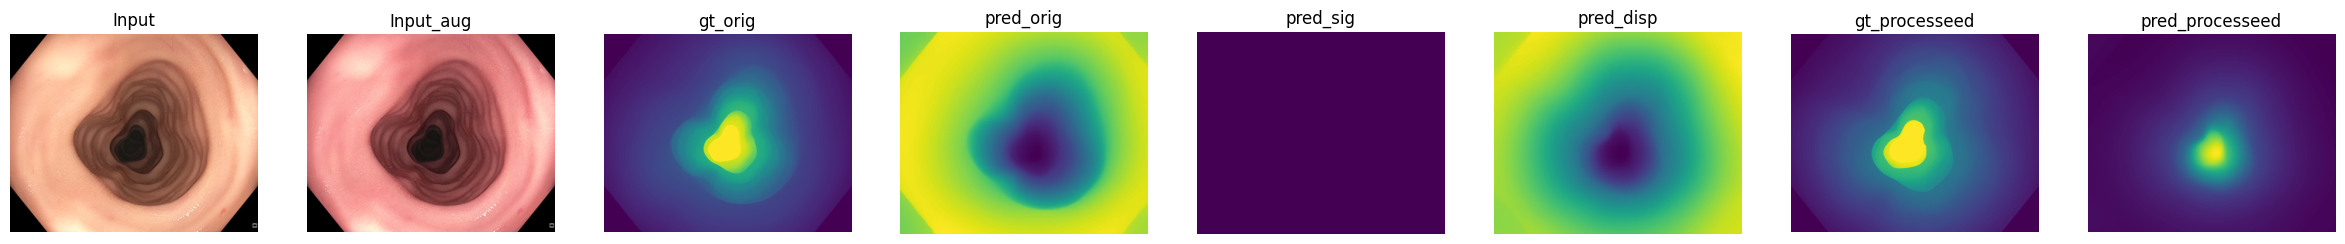

In [82]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from torch import nn

def disp_to_depth(disp, min_depth=0.1, max_depth=150):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_c3vd = C3VDDataset(data_path='/content/C3VD', height=256, width=320, frame_idxs=[0, -1, 1], num_scales=4, load_depth=True)
dataloader = DataLoader(dataset_c3vd, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)
print('sample size:', len(dataset_c3vd))
pretrained_weights = "depth-anything/Depth-Anything-V2-Large-hf"
image_processor = AutoImageProcessor.from_pretrained(pretrained_weights)
depth_model = DepthAnythingForDepthEstimation.from_pretrained(pretrained_weights)
depth_model.to(device)
depth_model.eval()
# prepare image for the model
MIN_DEPTH = 1e-3
MAX_DEPTH = 150
pred_disps = []
gt_depths = []

with torch.no_grad():
    for sample_batch in dataloader:
        depth_gt =sample_batch['depth_gt'].to(device)
        # inputs = image_processor(images=sample_batch['color', 0, 0], return_tensors="pt", do_rescale=False).to(device)
        # outputs = depth_model(**inputs)
        outputs = depth_model(sample_batch['color', 0, 0].to(device))
        predicted_depth = outputs.predicted_depth.unsqueeze(1)

        # predicted_depth_sig = nn.Sigmoid()(predicted_depth)
        # pred_disp, _ = disp_to_depth(predicted_depth_sig)
        # pred_disp = pred_disp.cpu()[:, 0].numpy()

        pred_disp = predicted_depth.cpu()[:, 0].numpy()

        pred_disps.append(pred_disp)
        gt_depths.append(sample_batch['depth_gt'])
        # prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),size=inputs['pixel_values'].shape[2:],mode="bicubic",align_corners=False)
        # break
    pred_disps = np.concatenate(pred_disps)
    gt_depths = np.concatenate(gt_depths).squeeze()

print('pred_disps:',pred_disps.shape, 'gt_depths:',gt_depths.shape)
errors = []
ratios = []

for i in range(pred_disps.shape[0]):
    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_disp = pred_disps[i]

    # pred_depth = cv2.resize(pred_disp, (gt_width, gt_height))

    pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
    pred_depth = 1/pred_disp

    # print('pred_disp3:', pred_disp.shape)
    mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)
    # print('mask:', mask.shape, 'pred_depth:', pred_depth.shape)
    # print('pred_depth8:',pred_depth.shape, 'gt_depth8:',gt_depth.shape)
    if i == 0:
        vis_gt_depth = gt_depth
        vis_pred_depth = pred_depth
    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]
    # print('pred_depth9:',pred_depth.shape, 'gt_depth9:',gt_depth.shape)

    # pred_depth *= opt.pred_depth_scale_factor
    # if not opt.disable_median_scaling:
    ratio = np.median(gt_depth) / np.median(pred_depth)
    ratios.append(ratio)
    pred_depth *= ratio
    # print('pred_depth10:',pred_depth.shape, 'gt_depth10:',gt_depth.shape)
    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
    # print('pred_depth11:',pred_depth.shape, 'gt_depth11:',gt_depth.shape)

    errors.append(compute_errors(gt_depth, pred_depth))


ratios = np.array(ratios)
med = np.median(ratios)
print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))

mean_errors = np.array(errors).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
plt.rcParams['figure.figsize'] = [30, 8]
plt.subplot(181); plt.axis('OFF'); plt.title('Input'); plt.imshow(sample_batch['color', 0, 0][0].permute(1,2,0))
plt.subplot(182); plt.axis('OFF'); plt.title('Input_aug'); plt.imshow(sample_batch["color_aug", 0, 0][0].permute(1,2,0))
plt.subplot(183); plt.axis('OFF'); plt.title('gt_orig'); plt.imshow(sample_batch['depth_gt'][0][0].cpu())
plt.subplot(184); plt.axis('OFF'); plt.title('pred_orig'); plt.imshow(predicted_depth[0][0].cpu())
plt.subplot(185); plt.axis('OFF'); plt.title('pred_sig'); plt.imshow(predicted_depth_sig[0][0].cpu())
plt.subplot(186); plt.axis('OFF'); plt.title('pred_disp'); plt.imshow(pred_disps[0])
plt.subplot(187); plt.axis('OFF'); plt.title('gt_processeed'); plt.imshow(vis_gt_depth)
plt.subplot(188); plt.axis('OFF'); plt.title('pred_processeed'); plt.imshow(vis_pred_depth)
print(inputs['pixel_values'].shape[2:], predicted_depth.shape, sample_batch['depth_gt'][0][0].shape)